In [1]:
from sortedcontainers import SortedList as ost
from math import floor,ceil,log,sqrt
from collections import deque
import numpy as np
from statistics import mean,variance
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Callable

In [14]:
!python -m pip install pymonad

  Using cached PyMonad-2.4.0-py3-none-any.whl.metadata (10 kB)
Using cached PyMonad-2.4.0-py3-none-any.whl (29 kB)

[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [15]:
from pymonad.tools import curry

def add(x, y):
    return x + y

curried_add = curry(2, add)
# add = curry(2, add) # If you don't need access to the uncurried version.

In [20]:
add1 = curried_add(2)

In [21]:
add1(3)

5

In [2]:
@dataclass
class sumstat :
    y : float 
    sy : float
    syy : float

In [3]:
def normal_mean(sumstats,a,b) :    
    val = sumstats[b+1].sy - sumstats[a].sy
    val *= val
    val /= (b - a + 1)
    val = -val
    val += sumstats[b+1].syy - sumstats[a].syy
    return val

In [4]:
# patterns : [closure,class,object,monad<writer>?]
def class_update_sumstats(wsize) : # sumstats class (a factory)
    sumstats = deque([sumstat(0.0,0.0,0.0)],maxlen = wsize)
    def update(y) :
        last = sumstats[-1]
        sumstats.append(sumstat(y,last.sy + y,last.syy + y*y))
        # TODO - if Y is full - normalize
        return sumstats,update
    return sumstats,update

In [26]:
# patterns : [hof,decorator,curry]
# TODO - domain needs implementing properly
def cost_function_decorator(sumstats,cost_function) :
    return curry(3,cost_function)(sumstats),None,len(sumstats) - 1
        
    

In [6]:
def fix_left(cost_function,position) :
    def value(i) :
        return cost_function(position,i)
    def size() :
        return cost_function.size()
    def domain(self) :
        return range(size())
    return(value,domain,size)

In [7]:
def fix_right(cost_function,position) :
    def value(i) :
        return cost_function(i,position)
    def size() :
        return cost_function.size()
    def domain(self) :
        return range(size())
    return(value,domain,size)

In [8]:
# patterns : [hof,closure,decorator?]
def split_left_right_sum(sumstats,cost_func) :
    def value(i) :
        if i == 0 :
            return value_r(i)
        else :
            return value_l(i) + value_r(i)
    def 
    return(value,domain,size)
    
    
    
    

SyntaxError: invalid syntax (4017624461.py, line 8)

In [ ]:
def left_right_sum(left,right) :
    value_l,domain,size = left
    value_r,_,_ = right
    def value(i) :
        if i == 0 :
            return value_r(i)
        else :
            return value_l(i) + value_r(i)
    return(value,domain,size)

In [30]:
Z = [float(z) for z in list(np.random.normal(0, 1, 1000)) + list(np.random.normal(1, 1, 1000)) + list(np.random.normal(0, 1, 1000))]

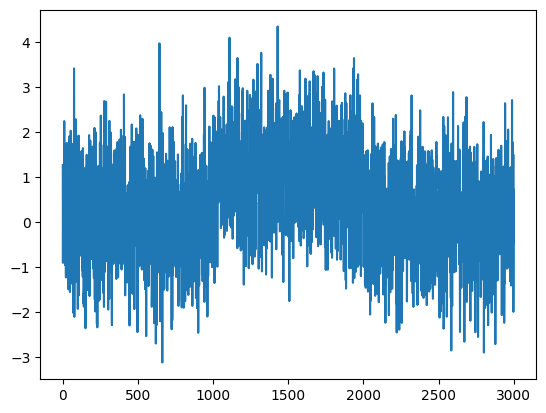

In [31]:
plt.plot(Z)

In [32]:
wsize = len(Z)
sumstats,update = class_update_sumstats(wsize)
for z in Z :
    sumstats,update = update(z)

In [36]:
cost,domain,size = cost_function_decorator(sumstats,normal_mean)

In [37]:
print(cost(0,0))
print(size)
print(domain)


1.1102230246251565e-16
2999
None


In [ ]:
sumstats